# CSTR Example

This example follows the example shown in [Zhang et al. (2019)](https://www.mdpi.com/2227-7390/7/10/890) where a continuous stirred tank reactor (CSTR) with a reversible exothermic reaction $A\leftrightarrow B$ is used to show how neural networks can be used with model predictive control to control and optimise a chemical process.

<img src="../images/CSTR_Example_image.png"  width="800">


In [1]:
# Add HILO-MPC to path. NOT NECESSARY if it was installed via pip.
import sys
sys.path.append('../../')

##### Import Libraries #####
import pandas as pd
import numpy as np
import math
import casadi as ca
import matplotlib.pyplot as plt
from hilo_mpc import Model
from hilo_mpc import ANN, Layer
from hilo_mpc import NMPC

# Ignore deprecation warnings coming from tensorflow
import warnings
warnings.filterwarnings("ignore")

## Process Model
The dynamic equations for the concentration of component A and B is obtained from the mass balance.  The [Arrhenius rate equation](https://en.wikipedia.org/wiki/Arrhenius_equation), $k=Ae^{\frac{-E_{a}}{RT}}$, is used as the reaction rate expression due to its [dependency on temperature](https://en.wikipedia.org/wiki/Reaction_rate).  The reactor temperature is described from the energy balance where the CSTR is modelled with a cooling jacket with duty Q.

$$
\begin{align}
    \frac{dC_{A}}{dt} &=  \frac{1}{\tau} \left(C_{A_{0}}-C_{A}\right) - r \label{eq1}\tag{1} \\
    \frac{dC_{B}}{dt} &= -\frac{1}{\tau}C_{B} + r \label{eq2}\tag{2} \\
    \frac{T}{dt} &= -\frac{\Delta H r}{\rho C_{P}} + \frac{1}{\tau} \left(T_{0}-T\right) + \frac{Q}{\rho C_{P} V} \label{eq3}\tag{3} \\
    r &=  k_{A}e^{\frac{-E_{A}}{RT}}C_{A} - k_{B}e^{\frac{-E_{B}}{RT}}C_{B} \label{eq4}\tag{4} \\
\end{align}
$$

### Notes and assumptions
 * It is assumed that both species have identical heat capacities and densities, thus the heat capacity and density of the mixture is assumed to be independent of the concentration of the different species.
 * The density is assumed to be independent of temperature.
 * The reactor is assumed to operate isobarically and adiabatically.
 * If $C_{A_{0}}$ is constant, then [equation 2](#mjx-eqn-eq2) is not necessary and $C_{B}=C_{A_{0}}-C_{A}$. In this example $C_{A_{0}}$ is constant but the full implementation is shown.
 * A low reactor temperature will result in a slow forward reaction rate and subsequently a low conversion of A.  A high reactor temperature will favour the reversible reaction and will result in a lower conversion of A.  The optimal conversion of A is achieved at 438.47K.

<img src="../images/CSTR_Example_Reaction_Rate.png">

### Parameter, steady-state, and limit values

<table>
<tr><td>

| Description               	     | Variable       | Value  	             | Unit        	         |
|:-----------------------------------|:--------------:|:--------------------:|:---------------------:|
| Initial Temperature          	     | $$T_{0}$$      | $$400$$    	         | $$K$$         	     |
| Residence Time               	     | $$\tau$$  	  | $$60$$     	         | $$s$$                 |
| Reaction Rate Constant for A 	     | $$k_{A}$$ 	  | $$5000$$   	         | $$\frac{1}{s}$$       |
| Reaction Rate Constant for B 	     | $$k_{B}$$	  | $$1\times10^{6}$$    | $$\frac{1}{s}$$       |
| Activation Energy for A            | $$E_{A}$$      | $$1\times10^{4}$$    | $$\frac{cal}{mol}$$   |
| Activation Energy for B            | $$E_{B}$$      | $$1.5\times10^{4}$$  | $$\frac{cal}{mol}$$   |
| Universal Gas Constant             | $$R$$          | $$1.987$$            | $$\frac{cal}{mol K}$$ |
| Heat of Reaction                   | $$\Delta H$$   | $$-5000$$            | $$\frac{cal}{mol}$$   |   
| Density of the Mixture             | $$\rho$$       | $$1$$                | $$\frac{kg}{L}$$      |
| Heat Capacity of the Mixture       | $$C_{P}$$      | $$1000$$             | $$\frac{cal}{kg K}$$  |
| Initial Concentration for A        | $$C_{A_{0}}$$  | $$1$$                | $$\frac{mol}{L}$$     |
| CSTR Volume                        | $$V$$          | $$100$$              | $$L $$                |
| Steady-state Concentration for A   | $$C_{A_{SS}}$$ | $$0.4912$$           | $$\frac{mol}{L}$$     |
| Steady-state Concentration for B   | $$C_{B_{SS}}$$ | $$0.5088$$           | $$\frac{mol}{L}$$     |
| Steady-state CSTR Temperature      | $$T_{SS}$$     | $$438.47$$           | $$K$$                 |
| Steady-state Cooling Jacket Duty   | $$Q_{SS}$$     | $$59881.84$$         | $$\frac{cal}{s}$$     |


</td></tr> </table>

<center>
    <b>Table 1: The parameters and steady-state values from [Zhang et al. (2019)]</b>
</center>

| Description           | Variable  | Lower Limit| Upper Limit    | Unit              |
|:----------------------|:---------:|:----------:|:--------------:|:-----------------:|
| Concentration for A   | $$C_{A}$$ | $$0$$      | $$1$$          | $$\frac{mol}{L}$$ |
| Concentration for B   | $$C_{B}$$ | $$0$$      | $$1$$          | $$\frac{mol}{L}$$ |
| Temperature           | $$T$$     | $$400$$    | $$500$$        | $$K$$         	  |
| Cooling Jacket Duty   | $$Q$$     | $$0$$      | $$10^{5}$$     | $$\frac{cal}{s}$$ |

<center>
    <b>Table 2: State and input limits from [Zhang et al. (2019)]</b>
</center>

In [2]:
##### Parameter, Steady-state, and Limit Values #####
# Parameter values
T_0 = 400
tau = 60
k_A = 5000
k_B = 1e6
E_A = 1e4
E_B = 1.5e4
R = 1.987
dH = -5000
rho = 1
Cp = 1000
C_A_0 = 1
V = 100
C_B_0 = 0 # Initial concentration for B is 0

# Steady-state values
C_A_SS = 0.4912
C_B_SS = 0.5088
T_SS = 438.47
Q_SS = 59881.84

# States and input limits
C_A_ll = 0.
C_A_ul = 1.
C_B_ll = 0.
C_B_ul = 1.
T_ll = 400.
T_ul = 500.
Q_ll = 0.
Q_ul = 1e5

# ANN training data limits
C_A_ll_nn = 0.
C_A_ul_nn = 1.
C_B_ll_nn = 0.
C_B_ul_nn = 1.
T_ll_nn = 400.
T_ul_nn = 500.

## Model Builder
The states are the concentration of species A, $C_{A}$, and B, $C_{B}$, as well as the reactor temperature, $T$. The heat rate of the cooling jacking is the only one input, $Q$.

The true plant model is used to compare against the hybrid model. Both the plant and hybrid model is defined similar with only the reaction rate defined as a parameter in the hybrid model.

In [3]:
##### Model Builder #####
def true_plant_model():
    true_plant_model = Model(plot_backend='bokeh', name='plant')
    x = true_plant_model.set_dynamical_states(['C_A', 'C_B', 'T'])
    u = true_plant_model.set_inputs(['Q'])

    # Unwrap states
    C_A = x[0]
    C_B = x[1]
    T = x[2]

    # Unwrap inputs
    Q = u[0]

    # Unknown reaction rates
    r = k_A * ca.exp((-E_A)/(R * T)) * C_A - k_B * ca.exp((-E_B)/(R * T)) * C_B

    dC_A = 1/tau * (C_A_0 - C_A) - r
    dC_B = -1/tau * C_B + r
    dT = - (dH * r)/(rho * Cp) + 1/tau * (T_0 - T) + Q / (rho * Cp * V)

    true_plant_model.set_dynamical_equations([dC_A, dC_B, dT])
    true_plant_model.set_measurement_equations([r])
    
    return true_plant_model

def hybrid_model():
    hybrid_model = Model(plot_backend='bokeh', name='model')
    x = hybrid_model.set_dynamical_states(['C_A', 'C_B', 'T'])
    u = hybrid_model.set_inputs(['Q'])
    p = hybrid_model.set_parameters(['r'])

    # Unwrap states
    C_A = x[0]
    C_B = x[1]
    T = x[2]

    # Unwrap inputs
    Q = u[0]

    # Unknown reaction rates
    r = p[0]

    dC_A = 1/tau * (C_A_0 - C_A) - r
    dC_B = -1/tau * C_B + r 
    dT = - (dH * r)/(rho * Cp) + 1/tau*(T_0 - T) + Q / (rho * Cp * V)   

    hybrid_model.set_dynamical_equations([dC_A, dC_B, dT])
    hybrid_model.set_measurement_equations([r])

    return hybrid_model

## Neural Network
The reaction rate expression ([equation 4](#mjx-eqn-eq4)) is difficult to obtain in practice.  Some reactions have complex reaction mechanisms resulting in a very complex rate expression.  Obtaining kinetic parameters are also difficult and costly.  Machine learning techniques can be used to obtain a reaction rate approximation using experimental/plant data.

### Training Data Generation
The assumed reaction rate expression and parameters for this example is used to create data to illustrate how a neural network can be used to model the reaction rate from data.  [Zhang *et al.* (2019)](https://www.mdpi.com/2227-7390/7/10/890) generated eight million data points (200 data points per feature) by varying the reactor temperature and concentrations of both components equidistantly. In this example only 20 data points per feature is used to get to a total of 800 data points.

In [4]:
##### Training Data Generation #####
training_data_array = []
data_points_per_feature = 20 # The size of the training data set will be data_points_per_feature^[number of features=3]

# Create ranges for the state variables

T_range = np.arange(T_ll_nn, T_ul_nn + (T_ul_nn - T_ll_nn) 
                    / data_points_per_feature, (T_ul_nn - T_ll_nn) / (data_points_per_feature - 1))

C_A_range = np.arange(C_A_ll_nn, C_A_ul_nn + (C_A_ul_nn - C_A_ll_nn) 
                      / data_points_per_feature, (C_A_ul_nn - C_A_ll_nn) / (data_points_per_feature - 1))

C_B_range = np.arange(C_B_ll_nn, C_B_ul_nn + (C_B_ul_nn - C_B_ll_nn) 
                      / data_points_per_feature, (C_B_ul_nn - C_B_ll_nn) / (data_points_per_feature - 1))

# Calculate the reaction rate at each combination
for T in T_range:
    for C_A in C_A_range:
        for C_B in C_B_range:
            r = k_A * math.exp((-E_A) / (R * T)) * C_A - k_B * math.exp((-E_B) / (R * T)) * C_B
            training_data_array.append([C_A, C_B, T, r])
                
df = pd.DataFrame(training_data_array, columns = ["C_A", "C_B", "T", "r"])

## Neural Network Parameters 

The neural network parameters are summarised in Table 3.
 
| Description                    | Article                       | Example                 |
|:-------------------------------|:------------------------------|:------------------------|
| Platform                       | Matlab Neural Network Toolbox | Python MPC Toolbox      |
| Training Algorithm / Optimiser | Levenberg-Marquardt           | Adam Optimiser          |
| Loss Function                  | Mean Square Error             | Mean Square Error       |
| Hidden Layers                  | 1                             | 1                       |
| Hidden Neurons                 | 10                            | 10                      |
| Activation Function            | tanh                          | tanh                    |
| Batch Size                     | n/a                           | 100                     |
| Maximum Number of Epochs       | n/a                           | 500                     |
| Validation Data Split          | n/a                           | 20%                     |
| Training Data Split            | n/a                           | 20%                     |
| Validation Stopping Criteria   | n/a                           | No change in 100 Epochs |
 
<center>
    <b>Table 3: Neural network parameters</b>
</center>


In [5]:
##### Neural Network #####
# Hyperparameters
    # Setup
learning_rate = 0.001
optimizer = 'Adam'
loss = 'mse'
backend = 'pytorch'
number_of_hidden_neurons = 10
activation_function = 'tanh'                   # See https://pytorch.org/docs/stable/nn.init.html for different activation functions
seed = '42'
device = 'cpu'
    # Training
batch_size = 100
epochs = 500
verbose = 0
validation_split = 0.2
test_split = 0.2
patience = 100

# Neural network features and labels
features = ['C_A', 'C_B', 'T']                 # States of the model
labels = ['r']                                 # Unknown parameter

# Create and train neural network
ann = ANN(features, 
          labels, 
          learning_rate = learning_rate,       # Default=0.001
          optimizer = optimizer,               # Default=Adam
          loss = loss,                         # Default=mse
          backend = backend)                   # Default=pytorch

# Add hidden layers to the nerual network
ann.add_layers(Layer.dense(number_of_hidden_neurons, activation = activation_function)) # Dense in Keras is similar to Linear in PyTorch

# Setup nerual network
ann.setup(seed = seed,                         # Default=42
          save_tensorboard = True,             # Default=False
          tensorboard_log_dir = './NN',        # Folder where ANN tensorboard model will be saved
          device = device)                     # CUDA is used if available. Device can also be set if required

# Add the dataset to the trainer
    # Data is Z-score/Standard score normalised (mean of the data is shifted to zero and standard deviation of 1 is created)
    # Output is scaled back
ann.add_data_set(df)

# Train nerual network
ann.train(batch_size = batch_size,             # Number of samples per gradient update.
          epochs = epochs,                     # Number of epochs to train the model.
          verbose = verbose,                   # Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch). Default=1
          validation_split = validation_split, # Fraction of the training data to be used as validation data. Default=0, range [0,1).
          test_split = test_split,             # Default=0, range [0,1)
          patience = patience,                 # Number of epochs with no improvement after which training will be stopped. Default=None, np.split()
          scaler = None,                       # Default=None (StandardScaler)
          scale_data = True,                   # Default=None
          scaler_backend = 'sklearn',          # Optional, Default=None
          shuffle = True)                      # Default=True, uses numpy.random.shuffle()

# To see the tensorboard results
# ann.show_tensorboard()

Evaluate on test data


## MPC
An economic model predictive controller (MPC) is used to control the plant at the set points.  The set points for the plant is calculated by the economic MPC.  The article uses a real-time optimisation (RTO) strategy with a Lyapunov-based MPC (LMPC).  Table 4 summarises the MPC parameters.

| Description           | Units             | Article             | Example             |
|:----------------------|:-----------------:|:-------------------:|:-------------------:|
| Sampling Period       | $$s$$             | $$5$$               | $$1$$               |
| Heating Price         | $$\frac{s}{cal}$$ | $$7 \times10^{-7}$$ | $$7 \times10^{-7}$$ |
| Prediction Horizon    | $$s$$             | $$10$$              | $$10$$              |
| Modelling Period      | $$s$$             | $$1000$$            | $$1000$$            |

<center>
    <b>Table 4: MPC parameters</b>
</center>

Scaling values where also chosen to ensure that all the state and input values are of the same oder.  The temperature of the reactor is scaled by 100 while the heat duty input was scaled by 100 000.

 ## Hybrid MPC Model Setup
 The reaction rate is substituted by the ANN model.  The reactor is assumed to be initially at steady-state. The basic economic MPC cost function is given by [Matschek *et al.* (2019)](https://link.springer.com/chapter/10.1007%2F978-3-319-77489-3_8) as:
 
 $$J_{economic}(x(t_{k}),\bar{u}_k(\cdot)) = \int_{t_{k}}^{t_{k}+T}L_{economic}(\bar{x}(\tau),\bar{u}_{k}(\tau))\:d \tau + E_{economic}(\bar{x}(t_{k}+T))$$
 
 No terminal cost is assumed, thus $E_{economical}=0$.  The stage cost is calculated by:
 
 $$L_{economic}(\bar{x}(\tau),\bar{u}_{k}(\tau))=\frac{C_{A}(\tau)}{C_{A_{0}}}+heat\:price \times Q(\tau) $$

In [7]:
##### Hybrid Model MPC Setup #####
# MPC Parameters
sampling_period = 1               # unit of time (dependent on the time units used in the modelling equations)
heat_price = 7e-7
modelling_period = 1000
prediction_horizon = 10
n_steps = int(modelling_period / sampling_period)
x_scaling_value = [1, 1, 1e2]
u_scaling_value = 1e5

# Plant Setup
plant = true_plant_model()
plant.setup(dt = sampling_period)
x0_plant = [C_A_0, C_B_0, T_0]
plant.set_initial_conditions(x0_plant)

# Model Setup
model = hybrid_model()
model.substitute_from(ann) # Substite the labels in the model with the ANN model
model.setup(dt = sampling_period)

# NMPC Hybrid Model Setup
nmpc_hybrid_model = NMPC(model)
nmpc_hybrid_model.set_scaling(x_scaling = x_scaling_value, u_scaling = u_scaling_value)
nmpc_hybrid_model.stage_cost.cost = model.x[0] / C_A_0 + model.u[0] * heat_price
nmpc_hybrid_model.horizon = prediction_horizon
nmpc_hybrid_model.set_box_constraints(x_lb = [C_A_ll, C_B_ll, T_ll], x_ub = [C_A_ul, C_B_ul, T_ul], 
                                      u_lb = [Q_ll], u_ub = [Q_ul])
nmpc_hybrid_model.set_initial_guess(x_guess = [C_A_SS, C_B_SS, T_SS], u_guess = [Q_SS])
nmpc_hybrid_model.setup(options = {'print_level':0})

# Solve NMPC
solution_hybrid = plant.solution
for step in range(n_steps):
    u = nmpc_hybrid_model.optimize(x0_plant)
    plant.simulate(u = u)
    x0_plant = solution_hybrid['x:f']

## Plant MPC Comparison
The true plant model is used to evaluate the performance of the hybrid MPC setup.

In [9]:
##### True Plant Model MPC Setup #####
# Plant Setup
plant = true_plant_model()
plant.setup(dt = sampling_period)
x0_plant = [C_A_0, C_B_0, T_0]
plant.set_initial_conditions(x0_plant)

# NMPC Plant Model Setup
nmpc_plant = NMPC(plant)
nmpc_plant.set_scaling(x_scaling = x_scaling_value, u_scaling = u_scaling_value)
nmpc_plant.stage_cost.cost = plant.x[0] / C_A_0 + plant.u[0] * heat_price
nmpc_plant.horizon = prediction_horizon
nmpc_plant.set_box_constraints(x_lb = [C_A_ll, C_B_ll, T_ll], x_ub = [C_A_ul, C_B_ul, T_ul], u_lb = [Q_ll], u_ub = [Q_ul])
nmpc_plant.set_initial_guess(x_guess = [C_A_SS, C_B_SS, T_SS], u_guess = [Q_SS])
nmpc_plant.setup(options = {'print_level':0})

# Solve NMPC
solution_true = plant.solution
for step in range(n_steps):
    u = nmpc_plant.optimize(x0_plant)
    plant.simulate(u = u)
    x0_plant = solution_true['x:f']

## MPC Performance Comparison

Hybrid: 	Q: 62690.0068 	C_A: 0.4913 	C_B: 0.5087 	T: 440.1573 	 Conversion: 50.87%
True: 		Q: 59882.1817 	C_A: 0.4912 	C_B: 0.5088 	T: 438.4732 	 Conversion: 50.88%


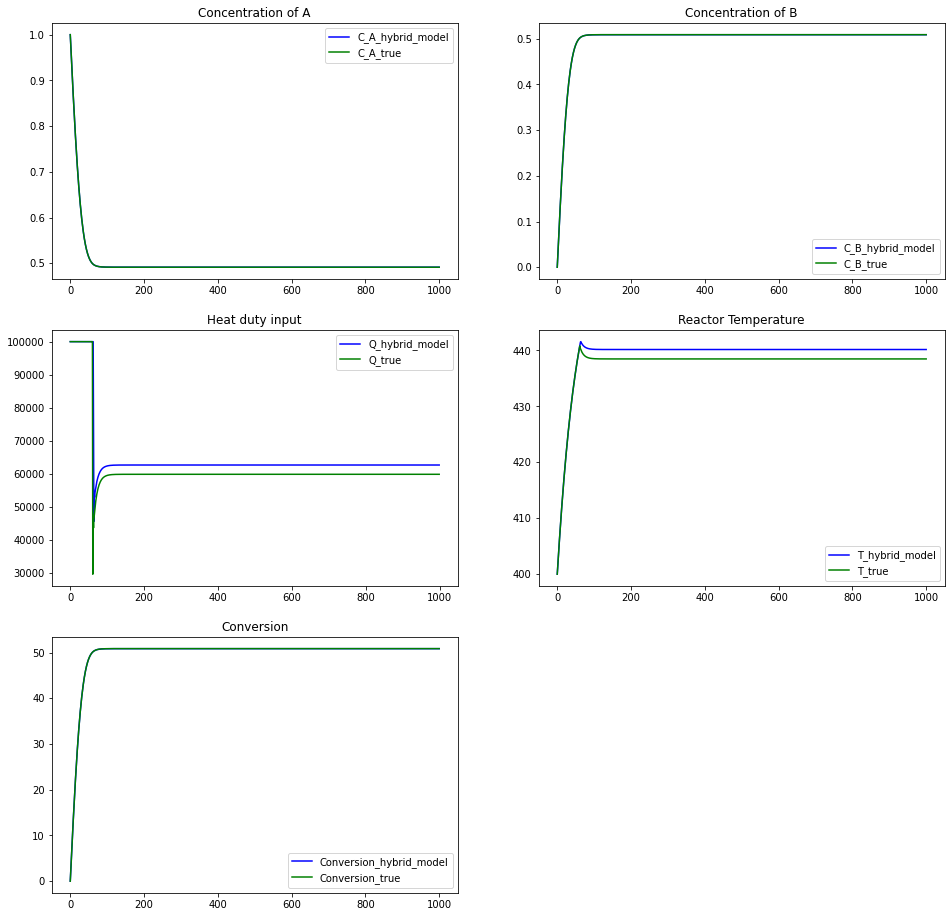

In [10]:
##### MPC Performance Comparison #####
# Solution Values
    # Hybrid Model
Q_hybrid_values = np.array(solution_hybrid['Q']).squeeze()
Ca_hybrid_values = np.array(solution_hybrid['C_A']).squeeze()
Cb_hybrid_values = np.array(solution_hybrid['C_B']).squeeze()
T_hybrid_values = np.array(solution_hybrid['T']).squeeze()
converson_hybrid_values = (1 - Ca_hybrid_values / C_A_0) * 100
    # True Plant Model
Q_true_values = np.array(solution_true['Q']).squeeze()
Ca_true_values = np.array(solution_true['C_A']).squeeze()
Cb_true_values = np.array(solution_true['C_B']).squeeze()
T_true_values = np.array(solution_true['T']).squeeze()
converson_true_values = (1 - Ca_true_values / C_A_0) * 100

# Final Values
print(f"Hybrid: \tQ: {Q_hybrid_values[-1]:.4f} \tC_A: {Ca_hybrid_values[-1]:.4f} \tC_B: {Cb_hybrid_values[-1]:.4f} \tT: {T_hybrid_values[-1]:.4f} \t Conversion: {converson_hybrid_values[-1]:.2f}%")
print(f"True: \t\tQ: {Q_true_values[-1]:.4f} \tC_A: {Ca_true_values[-1]:.4f} \tC_B: {Cb_true_values[-1]:.4f} \tT: {T_true_values[-1]:.4f} \t Conversion: {converson_true_values[-1]:.2f}%")

# Comparison Graphs
plt.figure(figsize=(16, 16)),
plt.subplot(321)
plt.plot(np.arange(Ca_hybrid_values.shape[0]),Ca_hybrid_values, 'b')
plt.plot(np.arange(Ca_true_values.shape[0]),Ca_true_values, 'g')
plt.legend(['C_A_hybrid_model','C_A_true'])
plt.title('Concentration of A')

plt.subplot(322)
plt.plot(np.arange(Cb_hybrid_values.shape[0]),Cb_hybrid_values, 'b')
plt.plot(np.arange(Cb_true_values.shape[0]),Cb_true_values, 'g')
plt.legend(['C_B_hybrid_model','C_B_true'])
plt.title('Concentration of B')

plt.subplot(323)
plt.plot(np.arange(Q_hybrid_values.shape[0]),Q_hybrid_values, 'b')
plt.plot(np.arange(Q_true_values.shape[0]),Q_true_values, 'g')
plt.legend(['Q_hybrid_model','Q_true'])
plt.title('Heat duty input')

plt.subplot(324)
plt.plot(np.arange(T_hybrid_values.shape[0]),T_hybrid_values, 'b')
plt.plot(np.arange(T_true_values.shape[0]),T_true_values, 'g')
plt.legend(['T_hybrid_model','T_true'])
plt.title('Reactor Temperature')

plt.subplot(325)
plt.plot(np.arange(converson_hybrid_values.shape[0]),converson_hybrid_values, 'b')
plt.plot(np.arange(converson_true_values.shape[0]),converson_true_values, 'g')
plt.legend(['Conversion_hybrid_model','Conversion_true'])
plt.title('Conversion')

plt.show()

## Acknowledgements
This example was gently provided by [Rudolph Kok](http://ifatwww.et.uni-magdeburg.de/syst/about_us/people/kok/index.shtml).